## Using scMulan to annotate cell types in Heart, Lung, Liver, Bone marrow, Blood, Brain, and Thymus

#### we provide a liver dataset sampled (percentage of 20%) from Suo C, 2022 (doi/10.1126/science.abo0510)
you can download the sampled dataset for this tutorial from: https://cloud.tsinghua.edu.cn/f/45a7fd2a27e543539f59/?dl=1  
ckpt could be downloaded from: https://cloud.tsinghua.edu.cn/f/2250c5df51034b2e9a85/?dl=1

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3" ## set your available devices, each use ~2G GPU-MEMORY
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # if use CPU only
import scanpy as sc

import scMulan
from scMulan import GeneSymbolUniform

## 1. load h5ad
It's recommended that you use h5ad here with raw count (and after your QC)

In [4]:
adata = sc.read('Data/liver.h5ad', backup_url='https://cloud.tsinghua.edu.cn/f/45a7fd2a27e543539f59/?dl=1')

In [5]:
adata

AnnData object with n_obs × n_vars = 27436 × 43878
    obs: 'cid', 'seq_tech', 'donor_ID', 'donor_gender', 'donor_age', 'donor_status', 'original_name', 'organ', 'region', 'subregion', 'sample_status', 'treatment', 'ethnicity', 'cell_type', 'cell_id', 'study_id'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    obsm: 'umap'

## 2. transform original h5ad with uniformed genes (42117 genes)

This step transform the genes in input adata to 42117 gene symbols and reserves the corresponding gene expression values.

In [6]:
adata_GS_uniformed = GeneSymbolUniform(input_adata=adata,
                                 output_dir="Data/",
                                 output_prefix='liver')

The shape of query data is: (27436, 43878)
The length of reference gene_list is: 42117
Performing gene symbol uniform, this step may take several minutes


Processing: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 43878/43878 [00:24<00:00, 1795.51it/s]

Building output data, this step may take several minutes



Processing: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42117/42117 [00:13<00:00, 3115.41it/s]


Shape of output data is (27436, 42117). It should have 42117 genes with cell number unchanged.
h5ad file saved in:/home/bianhaiyang/projects/cellgpt_v1/tools/scMulan_package/Data/liver_uniformed.h5ad
report file saved in: /home/bianhaiyang/projects/cellgpt_v1/tools/scMulan_package/Data/liver_report.csv


## 3. process uniformed data (simply norm and log1p)

In [21]:
## you can read the saved uniformed adata

#adata_GS_uniformed=sc.read_h5ad('Data/liver_uniformed.h5ad')

In [7]:
adata_GS_uniformed

AnnData object with n_obs × n_vars = 27436 × 42117
    obs: 'cid', 'seq_tech', 'donor_ID', 'donor_gender', 'donor_age', 'donor_status', 'original_name', 'organ', 'region', 'subregion', 'sample_status', 'treatment', 'ethnicity', 'cell_type', 'cell_id', 'study_id'

In [8]:
# norm and log1p count matrix
if adata_GS_uniformed.X.max() > 10:
    sc.pp.normalize_total(adata_GS_uniformed, target_sum=1e4) 
    sc.pp.log1p(adata_GS_uniformed)

## 4. load scMulan

In [9]:
# you should first download ckpt from https://cloud.tsinghua.edu.cn/f/2250c5df51034b2e9a85/?dl=1
# put it under .ckpt/ckpt_scMulan.pt
# by: wget https://cloud.tsinghua.edu.cn/f/2250c5df51034b2e9a85/?dl=1  -O ckpt/ckpt_scMulan.pt

ckp_path = 'ckpt/ckpt_scMulan.pt'

In [10]:
scml = scMulan.model_inference(ckp_path, adata_GS_uniformed)
base_process = scml.cuda_count()

number of parameters: 368.80M


/home/bianhaiyang/anaconda3/envs/cellgpt/lib/python3.9/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


✅ adata passed check
👸 scMulan is ready
scMulan is currently available to 4 GPUs.


In [11]:
scml.get_cell_types_and_embds_for_adata(parallel=True, n_process = base_process)
# scml.get_cell_types_and_embds_for_adata(parallel=False) # for only using CPU, but it is really slow.

adata is not sparse, use dense matrix and dataframe
⚡ Speed up by multiprocessing with 4 processes and 4 GPUs...


⏳ Generating cell type labels and embds for each cell on device 1: 100%|██████████| 6859/6859 [05:42<00:00, 20.00it/s]
⏳ Generating cell type labels and embds for each cell on device 0: 100%|██████████| 6859/6859 [05:46<00:00, 19.77it/s]
⏳ Generating cell type labels and embds for each cell on device 2: 100%|██████████| 6859/6859 [05:45<00:00, 19.83it/s]
⏳ Generating cell type labels and embds for each cell on device 3: 100%|██████████| 6859/6859 [05:45<00:00, 19.84it/s]


The predicted cell types are stored in scml.adata.obs['cell_type_from_scMulan'], besides the cell embeddings (for multibatch integration) in scml.adata.obsm['X_scMulan'] (not used in this tutorial).

## 5. visualization

In [13]:
adata_mulan = scml.adata.copy()

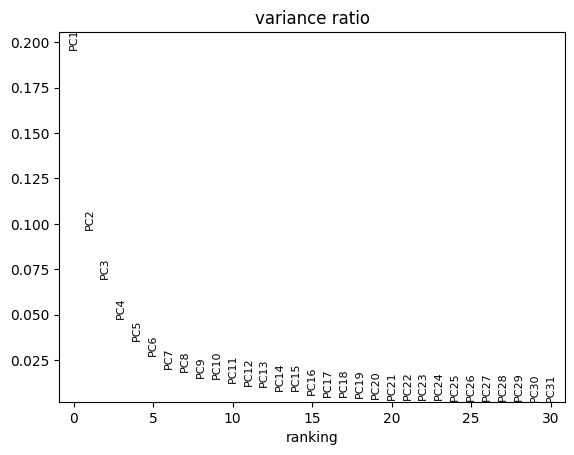

/home/bianhaiyang/anaconda3/envs/cellgpt/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/bianhaiyang/anaconda3/envs/cellgpt/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/bianhaiyang/anaconda3/envs/cellgpt/lib/python3.9/site-

In [14]:
sc.pp.pca(adata_mulan)
sc.pl.pca_variance_ratio(adata_mulan)
sc.pp.neighbors(adata_mulan,n_pcs=10)
sc.tl.umap(adata_mulan)

In [15]:
# you can run smoothing function to filter the false positives
scMulan.cell_type_smoothing(adata_mulan, threshold=0.1)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27436/27436 [00:12<00:00, 2241.23it/s]
/home/bianhaiyang/projects/cellgpt_v1/tools/scMulan_package/scMulan/utils/utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs.cell_type_from_mulan_smoothing[adata.obs.smoothing_score<threshold] = "Unclassified"
/home/bianhaiyang/anaconda3/envs/cellgpt/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1208: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/home/bianhaiyang/anaconda3/envs/cellgpt/lib/python3.9/site-packages/scanpy/p

/home/bianhaiyang/anaconda3/envs/cellgpt/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1208: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/home/bianhaiyang/anaconda3/envs/cellgpt/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/bianhaiyang/anaconda3/envs/cellgpt/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/bianhaiyang/anaconda3/envs/cellgpt/lib/python3.9/site-packages/scanpy/plotti

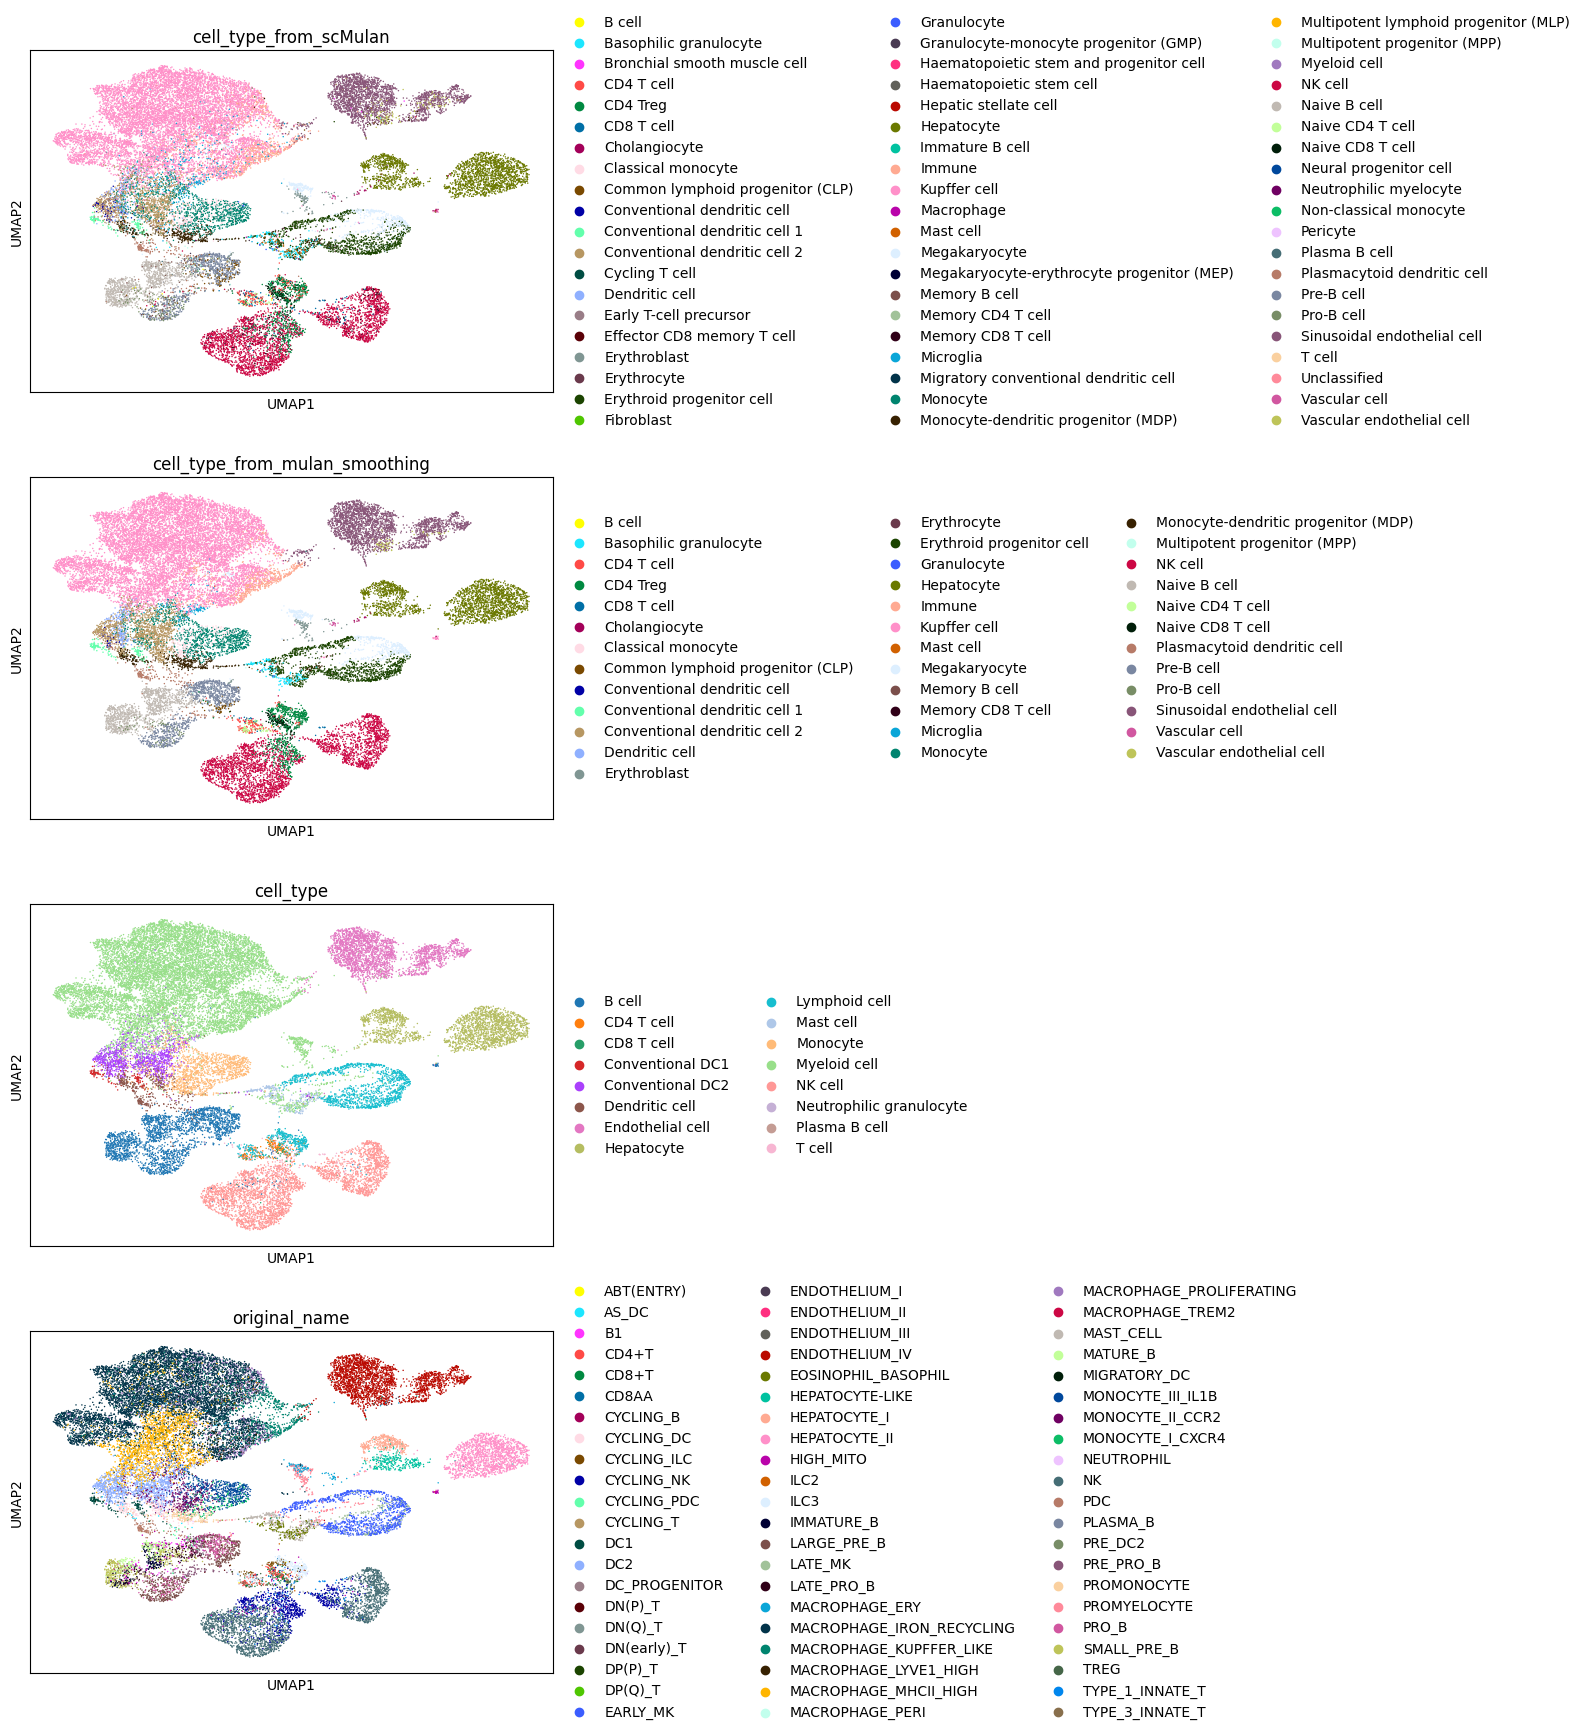

In [16]:
# cell_type_from_scMulan: pred
# cell_type_from_mulan_smoothing: pred+smoothing
# original_name: original annotations by the authors
# cell_type: cell types in hECA-10M that maps original_name to uHAF

sc.pl.umap(adata_mulan,color=["cell_type_from_scMulan","cell_type_from_mulan_smoothing",'cell_type','original_name'],ncols=1)

In [17]:
top_celltypes = adata_mulan.obs.cell_type_from_scMulan.value_counts().index[:20]

selected_celltype
Kupffer cell                           10049
NK cell                                 2960
Sinusoidal endothelial cell             2453
Hepatocyte                              2187
Conventional dendritic cell 2           1312
Erythroid progenitor cell               1206
Naive B cell                            1107
Monocyte                                1030
Pre-B cell                               980
others                                   854
Immune                                   683
CD4 Treg                                 678
Megakaryocyte                            518
Monocyte-dendritic progenitor (MDP)      389
Plasmacytoid dendritic cell              224
Dendritic cell                           216
Classical monocyte                       212
CD4 T cell                               156
Microglia                                121
Pro-B cell                                86
Memory CD8 T cell                         15
Name: count, dtype: int64


/home/bianhaiyang/anaconda3/envs/cellgpt/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1208: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/home/bianhaiyang/anaconda3/envs/cellgpt/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/bianhaiyang/anaconda3/envs/cellgpt/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


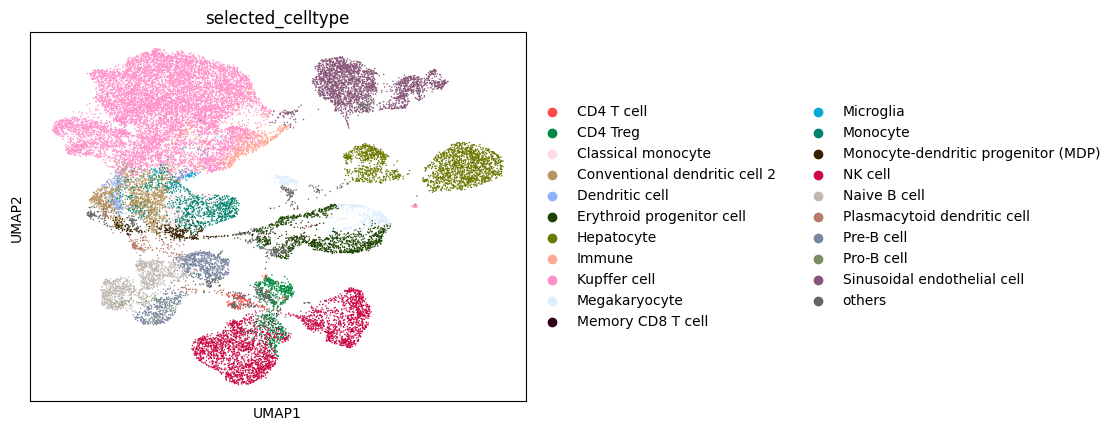

In [18]:
# you can select some cell types of interest (from scMulan's prediction) for visulization
# selected_cell_types = ["NK cell", "Kupffer cell", "Conventional dendritic cell 2"] # as example
selected_cell_types = top_celltypes
scMulan.visualize_selected_cell_types(adata_mulan,selected_cell_types,smoothing=True)